In [19]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier



In [20]:
df = pd.read_csv("TWF_Boosted.csv")

In [21]:
df.head()

,Unnamed: 0,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Temp_Delta,Power,Time/Part,TWF
0,0,0.0,298.2,308.4,1388.0,53.8,137.0,10.2,7819.884882,2.0,0
1,1,1.0,300.9,310.8,1599.0,33.0,7.0,9.9,5525.747318,3.0,0
2,2,0.0,301.4,310.5,1571.0,33.9,208.0,9.1,5577.049526,2.0,0
3,3,0.0,300.5,310.5,1373.0,47.4,56.0,10.0,6815.182607,2.0,0
4,4,1.0,297.3,308.8,1469.0,44.1,150.0,11.5,6784.049424,3.0,0


In [22]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Temp_Delta,Power,Time/Part,TWF
0,0.0,298.2,308.4,1388.0,53.8,137.0,10.2,7819.884882,2.0,0
1,1.0,300.9,310.8,1599.0,33.0,7.0,9.9,5525.747318,3.0,0
2,0.0,301.4,310.5,1571.0,33.9,208.0,9.1,5577.049526,2.0,0
3,0.0,300.5,310.5,1373.0,47.4,56.0,10.0,6815.182607,2.0,0
4,1.0,297.3,308.8,1469.0,44.1,150.0,11.5,6784.049424,3.0,0


In [23]:
for i in (('L', 0), ('M', 1), ('H', 2)):
    df['Type'] = df['Type'].replace(*i)

In [24]:
df.count()

Type                       15155
Air temperature [K]        15155
Process temperature [K]    15155
Rotational speed [rpm]     15155
Torque [Nm]                15155
Tool wear [min]            15155
Temp_Delta                 15155
Power                      15155
Time/Part                  15155
TWF                        15155
dtype: int64

In [25]:
df = df.rename(columns={'Air temperature [K]':'Air_temperature','Process temperature [K]':'Process_temperature',
                        'Rotational speed [rpm]': 'Rotational_speed','Torque [Nm]':'Torque','Tool wear [min]':'Tool_wear','Time/Part':'Part_Time'})

In [26]:
num_data = ['Air_temperature','Process_temperature','Rotational_speed','Torque','Tool_wear','Temp_Delta', 'Power']
categorical = ['Type', 'Part_Time']

target2 = ['TWF']

In [27]:
X = df.drop(columns=['TWF'])
y= df['TWF']

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[num_data] = scaler.fit_transform(df[num_data])

In [29]:
df[num_data]

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Temp_Delta,Power
0,-1.128392,-1.306327,-0.919889,1.607623,-0.318290,0.251648,1.690300
1,0.432012,0.523800,0.188166,-0.527442,-2.133272,-0.063723,-0.522193
2,0.720976,0.295034,0.041126,-0.435059,0.672970,-0.904712,-0.472716
3,0.200841,0.295034,-0.998660,0.950680,-1.449164,0.041401,0.721353
4,-1.648526,-1.001306,-0.494521,0.611943,-0.136792,1.618256,0.691328
...,...,...,...,...,...,...,...
15150,-0.654762,-0.639478,-0.521249,0.292718,0.683787,0.309428,0.206993
15151,-1.167581,-1.908292,0.193440,-0.202584,0.896744,-0.506923,-0.007907
15152,-0.485792,0.249825,2.412393,-1.733085,0.683374,1.228047,-1.561105
15153,0.083328,1.207553,0.135175,-0.625900,0.712178,1.513132,-0.720771


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

class XGBoostTuner:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.model = XGBClassifier()
        self.params = {
            'n_estimators': [1000, 1500, 2000],
            'max_depth': [3, 6, 8],
            'subsample': [0.90, 0.95, 1],
            'objective': ['binary:logistic', 'binary:hinge'],
            'min_child_weight': [5, 10, 15]
        }

    def tune_hyperparameters(self):     
        search = GridSearchCV(self.model, self.params, cv=5)
        search.fit(self.X_train, self.y_train)
        return search

# Assuming you have X_train and y_train defined
xgboost_tuner = XGBoostTuner(X_train, y_train)
search_results = xgboost_tuner.tune_hyperparameters()

best_model = search_results.best_estimator_
score = search_results.best_score_

print("Model Training:")
print(best_model)

print("Results:")
print(score)


Model Training:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=15, missing=nan, monotone_constraints=None,
              n_estimators=2000, n_jobs=None, num_parallel_tree=None,
              objective='binary:hinge', predictor=None, ...)
Results:
0.9968656051172129


In [31]:
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

class XGBoostTuner:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.model = XGBClassifier()
        self.params = {
            'n_estimators': [2000],
            'max_depth': [3],
            'subsample': [0.8],
            'objective': ['binary:hinge'],
            'min_child_weight': [10],
            'learning_rate': [0.05]
        }

    def tune_hyperparameters(self):     
        search = GridSearchCV(self.model, self.params, cv=5)
        search.fit(self.X_train, self.y_train)
        return search


xgboost_tuner = XGBoostTuner(X_train, y_train)
search_results = xgboost_tuner.tune_hyperparameters()

best_model = search_results.best_estimator_
score = search_results.best_score_

with open('xgboost_model_twf.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model Training:")
print(best_model)

print("Results:")
print(score)


Model Training:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=2000, n_jobs=None, num_parallel_tree=None,
              objective='binary:hinge', predictor=None, ...)
Results:
0.9971955700724712


Classification Report (Test Data):
              precision    recall  f1-score   support

           0     1.0000    0.9986    0.9993      1472
           1     0.9987    1.0000    0.9994      1559

    accuracy                         0.9993      3031
   macro avg     0.9994    0.9993    0.9993      3031
weighted avg     0.9993    0.9993    0.9993      3031

Confusion Matrix (Test Data):


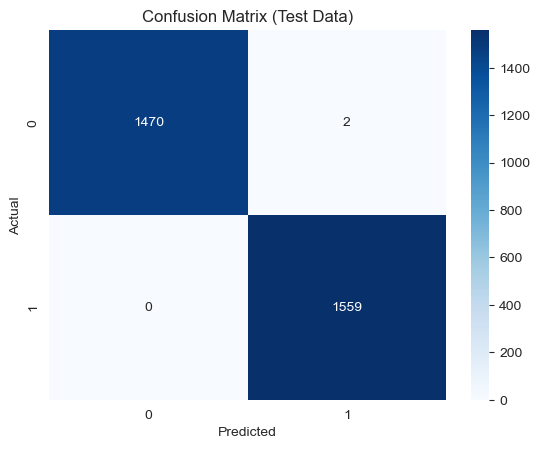

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class Xgboost_test:
    def __init__(self, X_test, y_test, best_model):
        self.X_test = X_test
        self.y_test = y_test
        self.best_model = best_model 

    def evaluate_model(self):
        y_pred = self.best_model.predict(self.X_test)
        return y_pred

# Assuming you have X_test and y_test defined
xgboost_tester = Xgboost_test(X_test, y_test, best_model)
y_pred_test = xgboost_tester.evaluate_model()

print('Classification Report (Test Data):')
print(classification_report(y_test, y_pred_test, digits=4))

print('Confusion Matrix (Test Data):')
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues')
plt.ylabel('Actual', fontsize=10)
plt.xlabel('Predicted', fontsize=10)
plt.title('Confusion Matrix (Test Data)', fontsize=12)
plt.show()

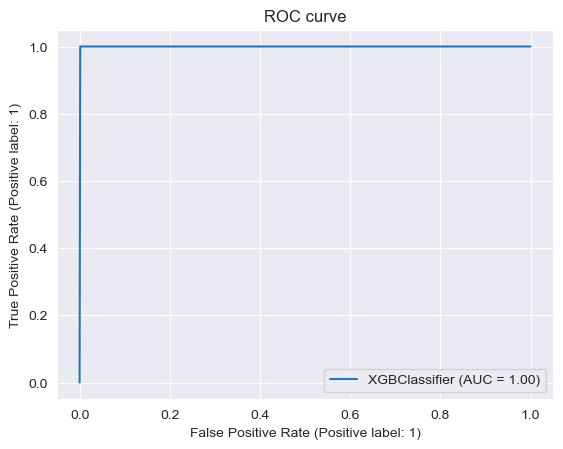

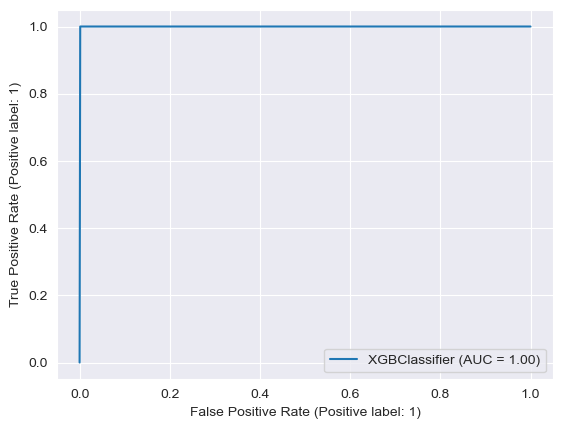

In [33]:
from sklearn.metrics import RocCurveDisplay

models = [search_results.best_estimator_] 

fig, ax = plt.subplots()

for model in models:
    display = RocCurveDisplay.from_estimator(model, X_test, y_test)
    display.plot(ax=ax)

ax.set_title("ROC curve")
plt.show()

In [49]:
import pickle
with open('xgboost_tuner_model_twf.pkl', 'wb') as file:
    pickle.dump(best_model, file)

#with open('xgboost_tuner_model_twf.pkl', 'rb') as file:
   # loaded_model = pickle.load(file)